## 目录|

1.目标函数 

2.搜索空间

3.存储评估试验

4.可视化

5.经典数据集上的完整示例：Iris

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import random

要使用下面的代码，你必须安装hyperopt和pymongo

### 1.目标函数

In [2]:
## 最优化一次函数
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=lambda x: x,  ##目标函数,一次函数
    space=hp.uniform('x', 0, 1),  ## 参数的定义域，最小为0
    algo=tpe.suggest,  ## 指定搜算算法 tpe：btree of parzen
    max_evals=100) ## 最大评估次数
print(best)

100%|████| 100/100 [00:00<00:00, 333.31it/s, best loss: 0.00012368270161630874]
{'x': 0.00012368270161630874}


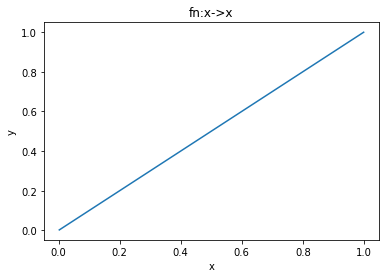

In [3]:
x =[random.uniform(0, 1) for i in range(100)] 
x.sort()
def fn(x):
    y = x
    return y
y = [fn(i) for i in x]
plt.title("fn:x->x") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.plot(x,y) 
plt.show()

In [4]:
## 最优化二次函数
best = fmin(
    fn=lambda x: (x-1)**2, ##目标函数，二次函数，最小值1
    space=hp.uniform('x', -2, 2), ## 参数定义域
    algo=tpe.suggest, ## 搜索算法tpe
    max_evals=100) ## 最大评估次数
print(best)

100%|████| 100/100 [00:00<00:00, 337.82it/s, best loss: 2.9971263766006735e-05]
{'x': 1.0054746016993026}


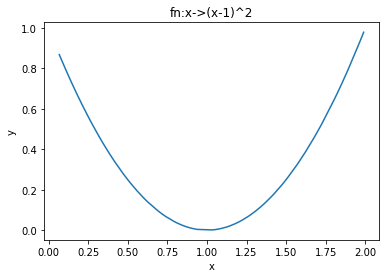

In [5]:
x =[random.uniform(0, 2) for i in range(100)] 
x.sort()
def fn(x):
    y = (x-1)**2
    return y
y = [fn(i) for i in x]
plt.title("fn:x->(x-1)^2") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.plot(x,y) 
plt.show()

我们想最大化的时候，返回函数的负数，负数的最小化就是本身的最大化.有时也许我们想要最大化目标函数，而不是最小化它。为此，我们只需要返回函数的负数（我们需要求最大损失函数，只需要求得负的损失函数的最小值）。
例如，我们有函数y(x) = -(x**2)的最大值：就是y(x) = (x**2)的最小值

In [6]:
## 最优化二次函数
best = fmin(
    fn=lambda x: (x**2), ##目标函数，二次函数，最小值1
    space=hp.uniform('x', -1, 1), ## 参数定义域
    algo=tpe.suggest, ## 搜索算法tpe
    max_evals=100) ## 最大评估次数
print(best)

100%|████| 100/100 [00:00<00:00, 346.00it/s, best loss: 1.8956865828544415e-07]
{'x': -0.000435394830338446}


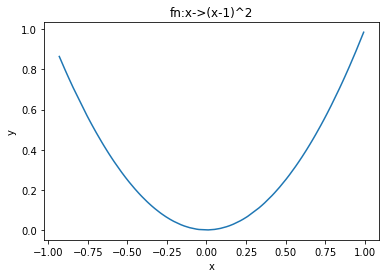

In [7]:
x =[random.uniform(-1, 1) for i in range(100)] 
x.sort()
def fn(x):
    y = (x)**2
    return y
y = [fn(i) for i in x]
plt.title("fn:x->(x-1)^2") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.plot(x,y) 
plt.show()

### 搜索空间

hyperopt模块包含一些方便的函数来指定输入参数的范围。
我们已经见过hp.uniform。最初，这些是随机搜索空间，但随着hyperopt更多的学习（因为它从目标函数获得更多反馈）
通过它认为提供给它最有意义的反馈，会调整并采样初始搜索空间的不同部分。

hp.choice(label, options) 其中options应是 python 列表或元组。

hp.normal(label, mu, sigma) 其中mu和sigma分别是均值和标准差。

hp.uniform(label, low, high) 其中low和high是范围的下限和上限。

#### 一个lgb超参空间的例子

In [8]:
# 定义超参数空间
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [9]:
import hyperopt.pyll.stochastic

space = {
    'x': hp.uniform('x', 0, 1), ## 定义域为(0,1)的均匀函数
    'y': hp.normal('y', 0, 1),  ## 定义域为(0,1)的正太函数
    'name': hp.choice('name', ['alice', 'bob']),  ## 多项选择
}
## 每次运行都会给出一个新的初始参数
print(hyperopt.pyll.stochastic.sample(space))

{'name': 'bob', 'x': 0.2905307085919492, 'y': 0.36381909707293175}


### 通过 Trials 捕获信息

我们需要一个追踪器去追踪Hyperopt里发生了什么

Trials对象使我们能够做到这一点。我们只需要导入一些东西。

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

fspace = {
    'x': hp.uniform('x', -5, 5)  ## 参数搜索空间 fspace
}

def f(params):
    x = params['x']   ## 从参数空间获取参数
    val = x**2       ## 目标函数
    return {'loss': val, 'status': STATUS_OK} 

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=1000, trials=trials)
print ('best:', best)

print ('trials:')
for trial in trials.trials[:2]:
    print (trial)
    print('\t')

100%|███| 1000/1000 [00:06<00:00, 160.32it/s, best loss: 1.918408157367246e-06]
best: {'x': -0.0013850661202149325}
trials:
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 2.4280076175682996, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [0]}, 'vals': {'x': [1.5582065388029598]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 6, 13, 7, 22, 32, 408000), 'refresh_time': datetime.datetime(2019, 6, 13, 7, 22, 32, 408000)}
	
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 7.395132222878965, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [1]}, 'vals': {'x': [-2.719399239331909]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 6, 13, 7, 22, 32, 411000), 'refresh_time': datetime.datetime(2019, 6, 13, 7, 22, 32, 411000)}
	


In [11]:
trials.best_trial  ## 看到最好的参数

{'book_time': datetime.datetime(2019, 6, 13, 7, 22, 32, 608000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'x': [74]},
  'tid': 74,
  'vals': {'x': [-0.0013850661202149325]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2019, 6, 13, 7, 22, 32, 608000),
 'result': {'loss': 1.918408157367246e-06, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 74,
 'version': 0}

In [12]:
trials.results[:2]

[{'loss': 2.4280076175682996, 'status': 'ok'},
 {'loss': 7.395132222878965, 'status': 'ok'}]

Trials对象将数据存储为BSON对象，其工作方式与JSON对象相同。BSON来自pymongo模块。这是对于需要使用MongoDB进行分布式计算的hyperopt的高级选项，因此需要导入pymongo。回到上面的输出。tid是时间 id，即时间步，其值从0到max_evals-1。它随着迭代次数递增。'x'是键'vals'的值，其中存储的是每次迭代参数的值。'loss'是键'result'的值，其给出了该次迭代目标函数的值。


## 可视化

Text(0,0.5,'$x$')

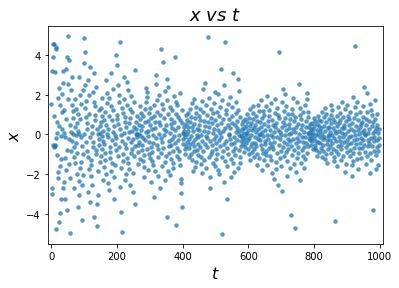

In [13]:
## 值 vs. 时间
import matplotlib.pyplot as  plt 
## jupyter notebook显示图片
% matplotlib inline 

f, ax = plt.subplots(1)  ## 新建一张图片
xs = [t['tid'] for t in trials.trials] ## 每次计算的id从0->max_evals
ys = [t['misc']['vals']['x'] for t in trials.trials] ## 从trials的json中提取x
ax.set_xlim(xs[0]-10, xs[-1]+10) ## 坐标轴左右增加10长度，显示更友好
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75) ##
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)

算法最初从整个空间均匀的选取数，随着时间的推移，参数和目标函数的交互越来越多，tpe算法会越来越集中于他认为会取得最大化收益的区域，一个接近0
的范围.它仍然探索整个解空间，但频率有所下降。

Text(0,0.5,'$val$')

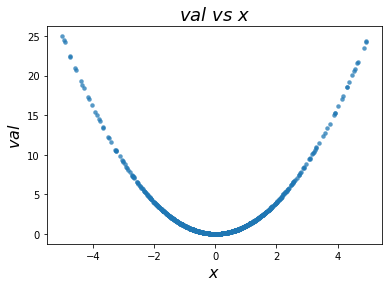

In [14]:
## 损失 vs. 值
f, ax = plt.subplots(1)  ## 建立新图，f为图片对象，ax为坐标轴
xs = [t['misc']['vals']['x'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$ ', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16)

它给了我们所期望的，x=0处取得最小，并且通过点的密度，可以看到在0处（最优解）的搜索次数最多。

### Iris实例

对于这项任务，我们将使用经典的Iris数据集，并进行一些有监督的机器学习。数据集有有4个输入特征和3个输出类别。数据被标记为属于类别0，1或2，其映射到不同种类的鸢尾花。

输入有4列：萼片长度，萼片宽度，花瓣长度和花瓣宽度。输入的单位是厘米。

我们将使用这4个特征来学习模型，预测三种输出类别之一

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris.feature_names) # input names
print(iris.target_names) # output names
print(iris.DESCR) # everything else

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
  species   measurement  value
0  setosa  sepal_length    5.1
1  setosa  sepal_length    4.9
2  setosa  sepal_length    4.7
3  setosa  sepal_length    4.6
4  setosa  sepal_length    5.0


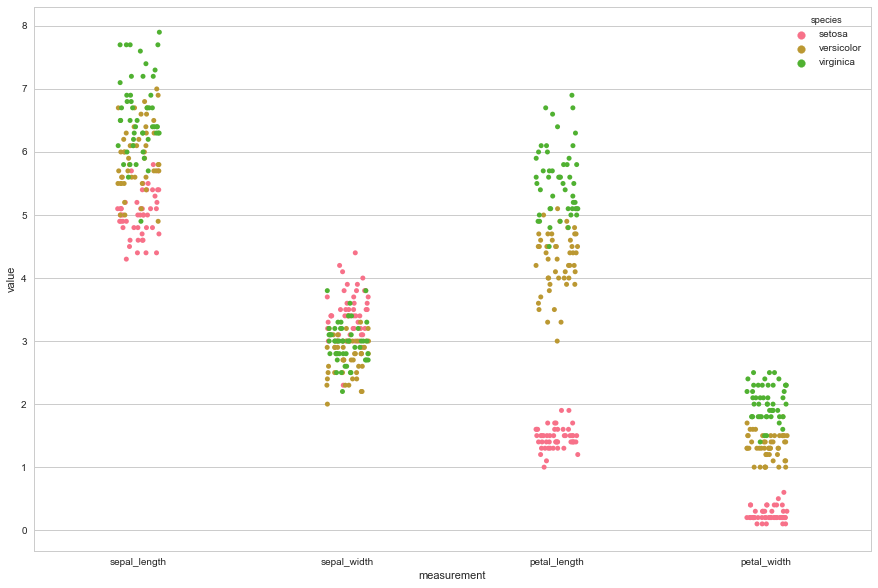

In [16]:
## 可视化了解数据
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid", palette="husl")  ## 图片为网格形式

iris = sns.load_dataset("iris")  ## seaborn下载iris数据
print(iris.head())

iris = pd.melt(iris, "species", var_name="measurement")  
print(iris.head())

f, ax = plt.subplots(1, figsize=(15,10))
sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax)

In [17]:
iris.columns

Index(['species', 'measurement', 'value'], dtype='object')

In [18]:
iris['measurement'].value_counts()

petal_width     150
petal_length    150
sepal_length    150
sepal_width     150
Name: measurement, dtype: int64

### K邻近

In [19]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

iris = datasets.load_iris()
X = iris.data
y = iris.target


## 使用HyperOpt调参，需要定义1.目标函数(AUC,KS等等)2.参数空间
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}


best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print ('new best:.{}{}'.format(best, params)) 
    return {'loss': -acc, 'status': STATUS_OK}
## 我们需要的是误差最大，所以返回的是-acc
trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

for trial in trials.trials[:2]:
    print (trial)

new best:.0.6397058823529411{'n_neighbors': 88}                                
new best:.0.9203431372549019{'n_neighbors': 38}                                
new best:.0.9869281045751634{'n_neighbors': 5}                                 
100%|████████| 100/100 [00:01<00:00, 59.69it/s, best loss: -0.9869281045751634]
best:
{'n_neighbors': 4}
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.6397058823529411, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'n_neighbors': [0]}, 'vals': {'n_neighbors': [87]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 6, 13, 7, 25, 26, 366000), 'refresh_time': datetime.datetime(2019, 6, 13, 7, 25, 26, 445000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': -0.9203431372549019, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'n_neighbors': [1]}, 'vals': {'n_neighbors': [37]

Text(0,0.5,'cross validation accuracy')

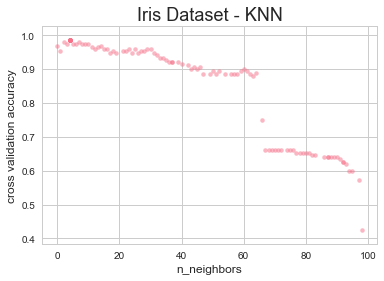

In [20]:
## 准确率和
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials] ## 获取x轴，自增id
ys = [-t['result']['loss'] for t in trials.trials] ## 获取y轴，loss
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5) ## 增加散点图，scatter(x,y,s,linewidth,alpha)
ax.set_title('Iris Dataset - KNN', fontsize=18) ## title 
ax.set_xlabel('n_neighbors', fontsize=12) #x label name
ax.set_ylabel('cross validation accuracy', fontsize=12) #y label name 

k 大于63后，准确率急剧下降。这是因为数据集中特征中每个类的数量。每个特征都包含三个类样本，每个类只有50个实例。导致临近点个数超过50效果下降迅速
所以让我们将'n_neighbors'的值限制为较小的值来进一步探索。

In [21]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:')
print(best) 

100%|████████| 100/100 [00:01<00:00, 76.98it/s, best loss: -0.9869281045751634]
best:
{'n_neighbors': 4}


Text(0,0.5,'cross validation accuracy')

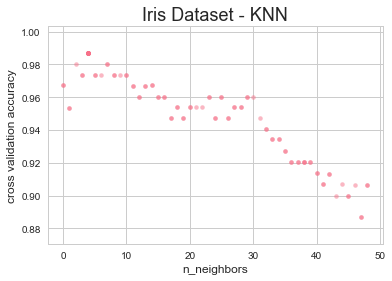

In [22]:
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials] ## 获取x轴，自增id
ys = [-t['result']['loss'] for t in trials.trials] ## 获取y轴，loss
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5) ## 增加散点图，scatter(x,y,s,linewidth,alpha)
ax.set_title('Iris Dataset - KNN', fontsize=18) ## title 
ax.set_xlabel('n_neighbors', fontsize=12) #x label name
ax.set_ylabel('cross validation accuracy', fontsize=12) #y label name 

In [23]:
# now with scaling as an option  #增加特征放缩（平时可以验证某种特征处理方式对模型效果的影响）
from sklearn import datasets
from sklearn.preprocessing import normalize,scale

iris = datasets.load_iris()
X = iris.data
y = iris.target


def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = KNeighborsClassifier(**params) ## fixed bugs modified **params -> the param classifier needs | increase indent of del
    return cross_val_score(clf, X_, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50)),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}


best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print ('new best:.{}{}'.format(best, params)) 
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:')
print(best) 

new best:.0.9464869281045751{'n_neighbors': 6}                                 
new best:.0.9669117647058822{'n_neighbors': 34}                                
new best:.0.9673202614379085{'n_neighbors': 1}                                 
new best:.0.9738562091503268{'n_neighbors': 12}                                
new best:.0.9803921568627452{'n_neighbors': 3}                                 
new best:.0.9869281045751634{'n_neighbors': 5}                                 
100%|████████| 100/100 [00:01<00:00, 55.77it/s, best loss: -0.9869281045751634]
best:
{'n_neighbors': 4, 'normalize': 0, 'scale': 0}


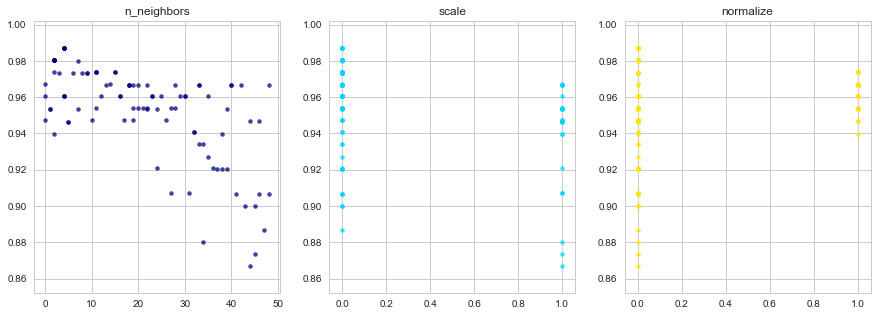

In [24]:
## 画图
import numpy as np
parameters = ['n_neighbors', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)

### 支持向量机（SVM）

new best:.0.920751633986928{'C': 9.945993026409477, 'gamma': 18.568950580411265, 'kernel': 'poly'}
new best:.0.9538398692810457{'C': 7.444250844781656, 'gamma': 2.775539773400717, 'kernel': 'poly'}
new best:.0.9738562091503268{'C': 12.192098767210418, 'gamma': 11.858425769292092, 'kernel': 'linear'}
100%|████████| 100/100 [00:02<00:00, 36.79it/s, best loss: -0.9738562091503268]
best:
{'C': 12.192098767210418, 'gamma': 11.858425769292092, 'kernel': 0, 'normalize': 0, 'scale': 0}


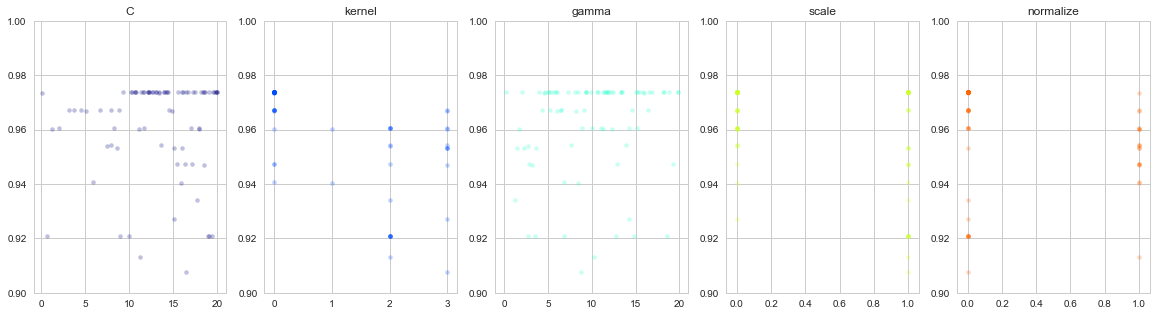

In [25]:
from  sklearn.svm import SVC
from sklearn.preprocessing import normalize,scale
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]

    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']

    clf = SVC(**params)
    return cross_val_score(clf, X_, y).mean()

space4svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}


best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print ('new best:.{}{}'.format(best, params)) 
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4svm, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:')
print(best) 

parameters = ['C', 'kernel', 'gamma', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    axes[i].set_ylim([0.9, 1.0])

### 决策树

In [26]:
from sklearn.tree import  DecisionTreeClassifier
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print ('new best:.{}{}'.format(best, params)) 
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)
print('best:')
print(best) 

new best:.0.9407679738562091{'criterion': 'entropy', 'max_depth': 2, 'max_features': 2}
new best:.0.9538398692810457{'criterion': 'gini', 'max_depth': 2, 'max_features': 2}
new best:.0.9607843137254902{'criterion': 'gini', 'max_depth': 14, 'max_features': 3}
new best:.0.9673202614379085{'criterion': 'entropy', 'max_depth': 7, 'max_features': 4}
new best:.0.9738562091503268{'criterion': 'gini', 'max_depth': 4, 'max_features': 3}
100%|████████| 300/300 [00:07<00:00, 42.44it/s, best loss: -0.9738562091503268]
best:
{'criterion': 0, 'max_depth': 3, 'max_features': 2, 'normalize': 0, 'scale': 0}


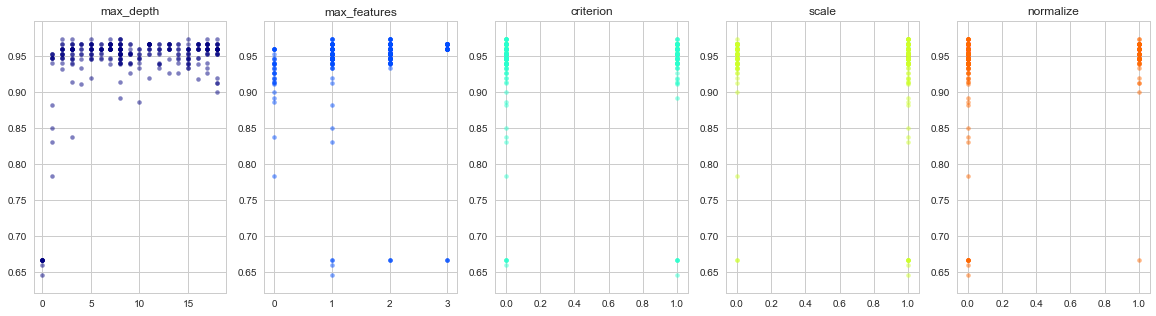

In [27]:
parameters = ['max_depth', 'max_features', 'criterion', 'scale', 'normalize'] # decision tree
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    #axes[i].set_ylim([0.9,1.0])

### 随机森林

In [28]:
from sklearn.ensemble import RandomForestClassifier
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print ('new best:.{}{}'.format(best, params)) 
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=200, trials=trials)
print('best:')
print(best)

new best:.0.960375816993464{'criterion': 'gini', 'max_depth': 14, 'max_features': 4, 'n_estimators': 17}
new best:.0.9673202614379085{'criterion': 'entropy', 'max_depth': 15, 'max_features': 3, 'n_estimators': 10}
new best:.0.9738562091503268{'criterion': 'gini', 'max_depth': 12, 'max_features': 2, 'n_estimators': 12}
100%|████████| 200/200 [00:15<00:00, 11.14it/s, best loss: -0.9738562091503268]
best:
{'criterion': 0, 'max_depth': 11, 'max_features': 1, 'n_estimators': 11, 'normalize': 1, 'scale': 1}
